# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
!pip install -q scikit-plot
import scikitplot as skplt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#for f1_Score
from sklearn.metrics import f1_score
#for roc curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import coo_matrix, hstack
from scipy import interp
from sklearn.metrics import classification_report
#for others
from tqdm import tqdm
import os
from google.colab import drive 
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# using SQLite Table to read data.
os.chdir("/content/drive/My Drive/Colab Notebooks") #changing directory
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#taking all data points since performing naive bayes
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:14<00:00, 1871.92it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similarly, performing preprocessing for Review Summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 364171/364171 [03:03<00:00, 1983.49it/s]


In [25]:
#Making the Splitting for train and test data
final['Text'] = preprocessed_reviews
final['Summary'] = preprocessed_summary
print(final.Text.shape,final.Summary.shape)


(364171,) (364171,)


In [26]:
#clearing memory
preprocessed_reviews = []
preprocessed_summary = []
#sampling 100k point for naive bayes. Also balancing the data
finalp = final[final.Score == 1].sample(50000,random_state =2)
finaln = final[final.Score == 0].sample(50000,random_state =2)
final = pd.concat([finalp,finaln],ignore_index=True)
final.Score.value_counts()

1    50000
0    50000
Name: Score, dtype: int64

In [0]:
#clearing memory
finalp= finaln = []
#splitting the data into train,cv and test
final = final.sort_values('Time')
y = final.Score.values
X = final.Text.values
from sklearn.model_selection import train_test_split
X_tr, X_test , y_tr, y_test = train_test_split(X,y,test_size=0.4)
X_cv,X_test,y_cv,y_test = train_test_split(X_test,y_test,test_size=0.5)


In [28]:
print(X_tr.shape,X_cv.shape,X_test.shape,y_tr.shape,y_cv.shape,y_test.shape)


(60000,) (20000,) (20000,) (60000,) (20000,) (20000,)


# [4] Featurization

## [4.1] BAG OF WORDS

Skipping BoW . Using BoW bigrams for better performance.

## [4.2] Bag Of Words using Bigrams

Using bi_grams for BoW.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect.fit_transform(X_tr)
cv_bigram_counts = count_vect.transform(X_cv)
test_bigram_counts = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 35570)
the number of unique words including both unigrams and bigrams  35570


In [30]:
test_bigram_counts.shape

(20000, 35570)

## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_tfidf= tf_idf_vect.fit_transform(X_tr)
cv_tfidf_values = count_vect.transform(X_cv)
test_tfidf_values = tf_idf_vect.transform(X_test)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer ",type(final_tfidf))
print("the shape of out text TFIDF vectorizer from train dara",final_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams from train data", final_tfidf.get_shape()[1])
print("the shape of out text TFIDF vectorizer from test data",test_tfidf_values.get_shape())
print("the number of unique words including both unigrams and bigrams from test data ", test_tfidf_values.get_shape()[1])


some sample features(unique words in the corpus) ['aafco', 'abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer from train dara (60000, 35570)
the number of unique words including both unigrams and bigrams from train data 35570
the shape of out text TFIDF vectorizer from test data (20000, 35570)
the number of unique words including both unigrams and bigrams from test data  35570


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

Define a function for simple cross validation.

In [0]:

#applying multnomialNB


#Defining a function for simple cross validation

def hyptuning_cv(xtrain,xcv):
#Finding optimal alpha
#Using AUC as metric
# creating list for alpha values ranging form 10^-4 to 10^4
  myList = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# empty list that will hold cv scores
#empty metric that holds training scores
  cv_scores = []
  tr_scores = []

# perform simple cross validation 
  for alpha in myList:
      clf = MultinomialNB(alpha = alpha)
      clf.fit(xtrain,y_tr)
      pred_tr = clf.predict(xtrain)
      AUC = roc_auc_score(y_tr,pred_tr)
      tr_scores.append(AUC)
      
  for alpha in myList:
      clf = MultinomialNB(alpha = alpha)
      clf.fit(xtrain,y_tr)
      pred = clf.predict(xcv)
      AUC = roc_auc_score(y_cv,pred)
      cv_scores.append(AUC)

# determining best alpha
# best alpha =  value between training alpha and validation alpha
#calculated as follows.

  optimal_alpha_cv = myList[cv_scores.index(max(cv_scores))]
  optimal_alpha_tr = myList[tr_scores.index(max(tr_scores))]
  log_tr = np.log(optimal_alpha_tr)
  log_cv = np.log(optimal_alpha_cv)
  optimal_alpha = float(np.exp((log_tr+log_cv)/2))
  print('\nThe optimal alpha for training data is %f and ROC is %f.' % (optimal_alpha_tr,max(tr_scores)))
  print('\nThe optimal alpha for validation data is %f and ROC is %f.' % (optimal_alpha_cv,max(cv_scores)))
  print('\nThe calculated optimal alpha for model is %f.' % optimal_alpha)
  
  

# plot misclassification error vs k 
  plt.title("AUC vs alpha")
  log_alphas = np.log(myList)
  plt.plot(log_alphas, tr_scores,'b',label='Train AUC')
  plt.plot(log_alphas, cv_scores,'darkorange',label='Validation AUC')
  plt.xlabel('Alpha Value in natural log')
  plt.ylabel('Area Under ROC Curve')
  plt.gca().legend()
  plt.show()
  return (optimal_alpha)

In [0]:
def naivebayes(alpha,Xtrain,Xtest):
#defining a function for naive bayes
  nb =  MultinomialNB(alpha = alpha)

# fitting the model
  nb.fit(Xtrain,y_tr)

# predict the response
  pred1 = nb.predict(Xtrain)
  pred = nb.predict(Xtest)
  coef = nb.feature_log_prob_
  AUC = roc_auc_score(y_test, pred) 
  return AUC,coef,pred,pred1
  


The optimal alpha for training data is 0.000010 and ROC is 0.917867.

The optimal alpha for validation data is 1.000000 and ROC is 0.885481.

The calculated optimal alpha for model is 0.003162.


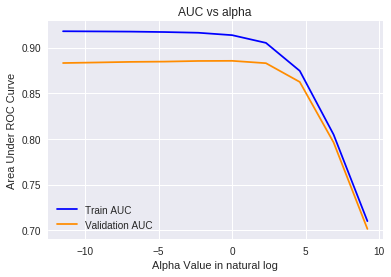

In [34]:
#applying naive bayes on simple cv for getting optimal alpha
alpha = hyptuning_cv(final_bigram_counts,cv_bigram_counts)
AUC,coef,pred,pred1 = naivebayes(alpha,final_bigram_counts,test_bigram_counts)


              precision    recall  f1-score   support

           0       0.89      0.89      0.89     10040
           1       0.89      0.89      0.89      9960

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



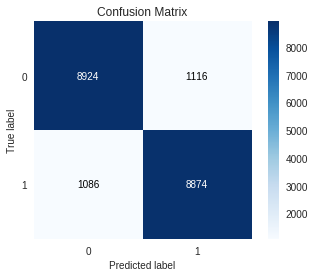

In [35]:
#plotting the confusion matrix

skplt.metrics.plot_confusion_matrix(y_test,pred)
print(classification_report(y_test ,pred))

In [0]:
###Refenced from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings ###
def roccurve(y_score,y_score2):
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr,tpr,_ = roc_curve(y_tr,y_score)
  roc_auc = roc_auc_score(y_tr,y_score) 
    
    
  fpr1 = dict()
  tpr1 = dict()
  roc_auc1 = dict()
  fpr1,tpr1,_ = roc_curve(y_test,y_score2)
  roc_auc1 = roc_auc_score(y_test,y_score2)
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='b',
           lw=lw, label='ROC curve for train data(area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')

  plt.plot(fpr1, tpr1, color='r',
           lw=lw, label='ROC curve for test data (area = %0.2f)' % roc_auc1)
  plt.legend(loc="lower right")
  plt.show()






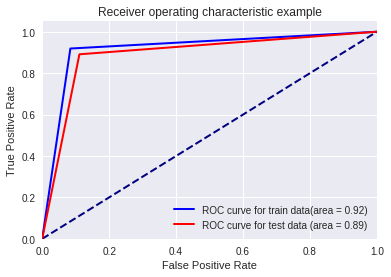

In [37]:
roccurve(pred1,pred)


Since, the area is greater than 0.5, it implies that model is good.

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [38]:
# Getting feature names from BoW vectorizer
features_BoW = count_vect.get_feature_names()
#Coef can't be used since it acts as a linear model, hence gives fatures for only one class.here coef = feature_log_prob_
#Merging them into a dataframe.
top_features = pd.DataFrame(coef,columns = features_BoW)
top_features = top_features.T
top_features.head(2)


,0,1
aafco,-12.018785,-12.826092
abandoned,-11.682403,-12.420890


In [39]:
#TOP 10 imp fatures of positive class from set1 
print(top_features[1].sort_values(ascending=False)[0:10])

not       -3.982762
like      -4.825527
good      -4.930794
great     -5.002136
one       -5.121844
taste     -5.217019
tea       -5.299760
flavor    -5.330645
coffee    -5.334818
product   -5.338728
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [40]:
print(top_features[0].sort_values(ascending=False)[0:10])

not       -3.527698
like      -4.651014
product   -4.908405
would     -4.915450
taste     -4.947019
one       -5.121093
good      -5.376875
no        -5.399295
flavor    -5.413668
coffee    -5.437215
Name: 0, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>


The optimal alpha for training data is 0.000010 and ROC is 0.927850.

The optimal alpha for validation data is 0.100000 and ROC is 0.887794.

The calculated optimal alpha for model is 0.001000.


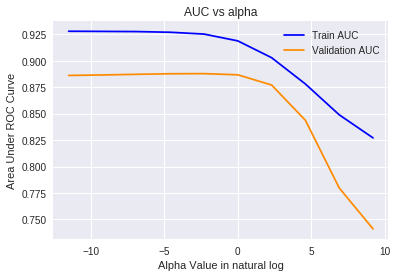

In [41]:
#Applying simple CV to get optimal alpha
alpha = hyptuning_cv(final_tfidf,cv_tfidf_values)
#applying naive bayes using optimal alpha
AUC,coef,pred,pred1 = naivebayes(alpha,final_tfidf,test_tfidf_values)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     10040
           1       0.90      0.89      0.89      9960

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



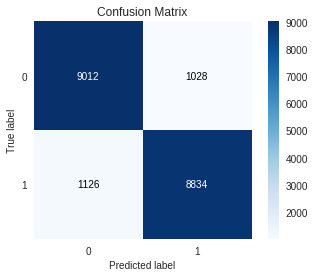

In [42]:
#plotting the confusion matrix

skplt.metrics.plot_confusion_matrix(y_test,pred)
print(classification_report(y_test ,pred))

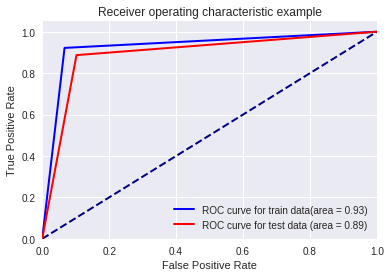

In [43]:
#plotting the ROC Area Curve
roccurve(pred1,pred)


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [44]:
# Getting feature from tfidf vectorizer
features_tfidf = tf_idf_vect.get_feature_names()
#Coef can't be used since it acts as a linear model, hence gives fatures for only one class.here coef = feature_log_prob_
#Merging them into a dataframe.
top_features = pd.DataFrame(coef,columns = features_tfidf)
top_features = top_features.T
top_features.head(2)

,0,1
aafco,-12.435514,-13.158774
abandoned,-11.353424,-12.194460


In [45]:
#TOP 10 imp fatures of positive class from set1 
print(top_features[1].sort_values(ascending=False)[0:10])

not       -5.369474
great     -5.505303
good      -5.651786
love      -5.777756
like      -5.795173
tea       -5.795826
coffee    -5.832508
one       -5.972246
flavor    -6.007751
product   -6.016648
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [46]:
#TOP 10 imp fatures of negative class from set2
print(top_features[0].sort_values(ascending=False)[0:10])

not       -4.803448
like      -5.562866
product   -5.657305
taste     -5.692201
would     -5.734153
coffee    -5.947743
one       -5.949630
flavor    -6.079581
no        -6.089572
good      -6.145962
Name: 0, dtype: float64


# [6] Feature Engineering:
Taking 2 addtional features.
1) Summary of the reviews.
2) Helpfulness Numerator/Denominator



# [6.1] Applying Naive Bayes on BoW using addtional 2 new features.





In [0]:
#Taking text summary as well as addtional feature
#Taking helpfulness numerator/denominator as another feature.
#splitting the data into train and test
y = final.Score.values
X = final.Text.values
X = final.Summary.str.cat(X, sep=' ')
numdum = []
numdum =final.HelpfulnessNumerator/final.HelpfulnessDenominator
numdum = np.nan_to_num(numdum)
#Reshaping numdum so that it can be column concatenated with sparse matrices
numdum = numdum.reshape(100000,1)

In [0]:
#Splitting Data
numdum_tr,numdum_test = train_test_split(numdum,test_size=0.4)
numdum_cv,numdum_test = train_test_split(numdum_test,test_size=0.5)
X_tr, X_test , y_tr, y_test = train_test_split(X,y,test_size=0.4)
X_cv,X_test,y_cv,y_test = train_test_split(X_test,y_test,test_size=0.5)


In [49]:
#BoW
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect.fit_transform(X_tr)
cv_bigram_counts = count_vect.transform(X_cv)
test_bigram_counts = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 37926)
the number of unique words including both unigrams and bigrams  37926


In [0]:
#Merging num/dum with BoW using hstack
final_bigram_counts = hstack((final_bigram_counts,numdum_tr))

In [51]:
final_bigram_counts.shape

(60000, 37927)

In [0]:
test_bigram_counts = hstack((test_bigram_counts,numdum_test))
cv_bigram_counts = hstack((cv_bigram_counts,numdum_cv))


The optimal alpha for training data is 0.000010 and ROC is 0.935039.

The optimal alpha for validation data is 0.100000 and ROC is 0.915070.

The calculated optimal alpha for model is 0.001000.


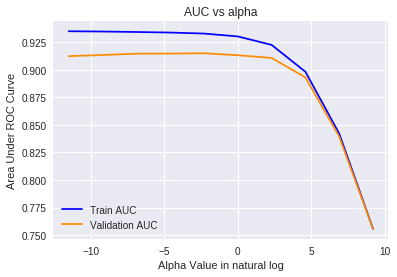

In [53]:
#Hypertuning and then applying naivebayes
#applying naive bayes on simple cv for getting optimal alpha
alpha = hyptuning_cv(final_bigram_counts,cv_bigram_counts)

AUC,coef,pred,pred1 = naivebayes(alpha,final_bigram_counts,test_bigram_counts)



              precision    recall  f1-score   support

           0       0.91      0.90      0.91     10017
           1       0.90      0.91      0.91      9983

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



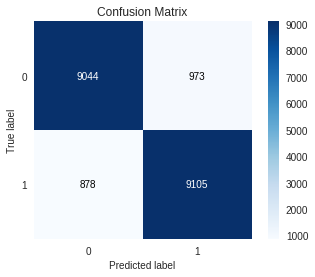

In [54]:
#plotting the confusion matrix

skplt.metrics.plot_confusion_matrix(y_test,pred)
print(classification_report(y_test ,pred))

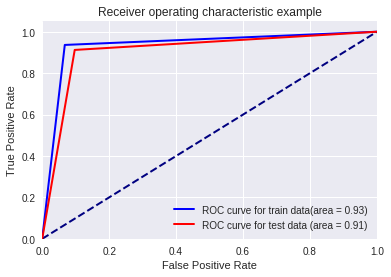

In [55]:
#plotting the ROC Area Curve
roccurve(pred1,pred)


# [6.2] Applying Naive Bayes on TFIDF using addtional 2 New Features.

Data has already been preprocessed. Proceeding with tfidf vectorizer.

In [56]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_tfidf= tf_idf_vect.fit_transform(X_tr)
cv_tfidf_values = count_vect.transform(X_cv)
test_tfidf_values = tf_idf_vect.transform(X_test)



print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer ",type(final_tfidf))
print("the shape of out text TFIDF vectorizer from train dara",final_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams from train data", final_tfidf.get_shape()[1])
print("the shape of out text TFIDF vectorizer from test data",test_tfidf_values.get_shape())
print("the number of unique words including both unigrams and bigrams from test data ", test_tfidf_values.get_shape()[1])


some sample features(unique words in the corpus) ['aa', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'ability', 'able', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer from train dara (60000, 37926)
the number of unique words including both unigrams and bigrams from train data 37926
the shape of out text TFIDF vectorizer from test data (20000, 37926)
the number of unique words including both unigrams and bigrams from test data  37926


In [0]:
#Adding the helpfulness num/den column
final_tfidf = hstack((final_tfidf,numdum_tr))
cv_tfidf_values = hstack((cv_tfidf_values,numdum_cv))
test_tfidf_values = hstack((test_tfidf_values,numdum_test))


The optimal alpha for training data is 0.000010 and ROC is 0.940617.

The optimal alpha for validation data is 0.010000 and ROC is 0.917577.

The calculated optimal alpha for model is 0.000316.


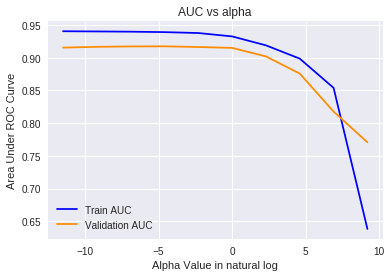

In [58]:
#Applying simple CV to get optimal alpha
alpha = hyptuning_cv(final_tfidf,cv_tfidf_values)
#applying naive bayes using optimal alpha
AUC,coef,pred,pred1 = naivebayes(alpha,final_tfidf,test_tfidf_values)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     10017
           1       0.91      0.90      0.91      9983

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



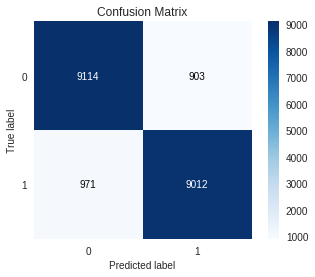

In [59]:
#plotting the confusion matrix

skplt.metrics.plot_confusion_matrix(y_test,pred)
print(classification_report(y_test ,pred))

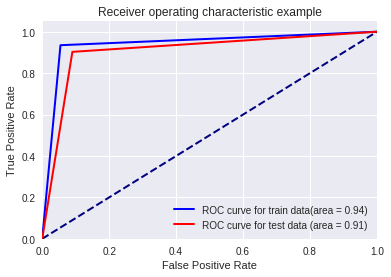

In [60]:
#plotting the ROC Area Curve
roccurve(pred1,pred)


# [7] Conclusion

In [0]:
!pip install -q PTable
from prettytable import PrettyTable
x= PrettyTable()
x.field_names = ["Vectorizer","Model","Hyperparameter Alpha","AUC"]
x.add_row(["BoW", 'Naive Bayes', '0.003162', '0.89'])
x.add_row(["tfidf", 'Naive Bayes', '0.001', '0.89'])
x.add_row(["BoW(+2 features)", 'Naive Bayes', '0.001', '0.91'])
x.add_row(["tfidf(+2 features)", 'Naive Bayes', '0.001', '0.91'])







In [64]:
print(x)

+--------------------+-------------+----------------------+------+
|     Vectorizer     |    Model    | Hyperparameter Alpha | AUC  |
+--------------------+-------------+----------------------+------+
|        BoW         | Naive Bayes |       0.003162       | 0.89 |
|       tfidf        | Naive Bayes |        0.001         | 0.89 |
|  BoW(+2 features)  | Naive Bayes |        0.001         | 0.91 |
| tfidf(+2 features) | Naive Bayes |        0.001         | 0.91 |
+--------------------+-------------+----------------------+------+


 Conclusions:
 
1.   Takes Less time compare to KNN

2.   Alpha value is taken between the train and validation data. Hence, the models are well-fit.Bias_variance trade-off is necessary for a well-fit model.

3.  ROC_AUC Curve is greater than 0.5 for all 4 models.

4.  Confusion matrix shows the True positives,False positives,True Negatives, and Flase postives. It can be concluded that the models are good , based on the values, as the True values are balanced and substantially more than the False values.

5.    When 2 features are added, i.e the summary of the reviews and the helpfulness ratio,
it can be observed that AUC score increased by 2% approx.
It can be concluded that, models can perform better if these features are included.

6. In W2V, the features are dependent on each other. But in naive bayes, we consider the features are independent of each other. Although naive bayes might perform well,it makes no sense to apply naive bayes on this.Hence, it might be the reason that the assignment consists only of BoW and TFIDF.